# 1. NASA Turbofan Jet Engine Data Set

## Run to Failure Degradation Simulation

Source: https://www.kaggle.com/datasets/behrad3d/nasa-cmaps

### Conceptual Steps:

1. **Load and Clean Data**: Ensure the data is correctly loaded and cleaned, including handling missing values and ensuring correct data types.
2. **Feature Engineering**: Create meaningful features that capture the degradation patterns of each engine. This can include:
   - **Trends**: Calculate trends in sensor measurements over time.
   - **Statistical Summaries**: Compute summary statistics (mean, variance, min, max) of sensor measurements.
   - **Operational Settings**: Include operational settings as features.
3. **Training the Model**: Train the machine learning models using these engineered features to capture the unique "signature" of each engine.
4. **Predicting and Evaluating**: Use the trained model to predict the RUL for each engine in the test dataset and evaluate the predictions against the actual RUL values.

### Detailed Explanation:

1. **Load and Clean Data**:
   - Ensure data is loaded without errors and columns are correctly interpreted.
   - Handle any missing values appropriately.

2. **Feature Engineering**:
   - **Trends**: Capture how sensor readings change over time for each engine.
   - **Statistical Summaries**: Summarize the behavior of sensor readings with statistical measures.
   - **Operational Settings**: Incorporate the operational settings to account for different operating conditions.

3. **Training the Model**:
   - Use the engineered features to train the model. Models like Random Forests or Gradient Boosting can capture complex relationships in the data.

4. **Predicting and Evaluating**:
   - Make predictions on the test data and compare them with actual RUL values.
   - Use evaluation metrics such as RMSE to assess the model's performance.



# 2. Linear Regression and Support Vector Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

def load_data(train_file, test_file, rul_file):
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    return train_data, test_data, rul_data

def calculate_rul(df):
    max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']
    df = df.merge(max_cycles, on='unit_number')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    return df.drop(columns=['max_cycle'])

def create_aggregated_features(df):
    aggregated_features = df.groupby('unit_number').agg({
        'time_in_cycles': ['max'],
        'RUL': ['min'],  # Use the minimum RUL for each unit
        **{f'operational_setting_{i}': ['mean', 'std'] for i in range(1, 4)},
        **{f'sensor_measurement_{i}': ['mean', 'std', 'min', 'max'] for i in range(1, 22)}
    }).reset_index()
    aggregated_features.columns = ['_'.join(col).strip() for col in aggregated_features.columns.values]
    return aggregated_features

def preprocess_data(train_data, test_data):
    train_data = calculate_rul(train_data)
    test_data = calculate_rul(test_data)

    train_aggregated_features = create_aggregated_features(train_data)
    test_aggregated_features = create_aggregated_features(test_data)

    feature_columns = train_aggregated_features.columns.difference(['unit_number_', 'time_in_cycles_max', 'RUL_min'])
    X_train = train_aggregated_features[feature_columns]
    y_train = train_aggregated_features['RUL_min']
    X_test = test_aggregated_features[feature_columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, y_train, X_test_pca

def train_models(X_train_pca, y_train):
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    svr_model = SVR(kernel='rbf')

    lr_model.fit(X_train_pca, y_train)
    rf_model.fit(X_train_pca, y_train)
    svr_model.fit(X_train_pca, y_train)

    return lr_model, rf_model, svr_model

def evaluate_models(rul_data, lr_predictions, rf_predictions, svr_predictions):
    metrics = {}

    metrics['lr_rmse'] = mean_squared_error(rul_data, lr_predictions, squared=False)
    #metrics['rf_rmse'] = mean_squared_error(rul_data, rf_predictions, squared=False)
    metrics['svr_rmse'] = mean_squared_error(rul_data, svr_predictions, squared=False)

    metrics['lr_mae'] = mean_absolute_error(rul_data, lr_predictions)
    #metrics['rf_mae'] = mean_absolute_error(rul_data, rf_predictions)
    metrics['svr_mae'] = mean_absolute_error(rul_data, svr_predictions)

    metrics['lr_mse'] = mean_squared_error(rul_data, lr_predictions)
    #metrics['rf_mse'] = mean_squared_error(rul_data, rf_predictions)
    metrics['svr_mse'] = mean_squared_error(rul_data, svr_predictions)

    metrics['lr_r2'] = r2_score(rul_data, lr_predictions)
    #metrics['rf_r2'] = r2_score(rul_data, rf_predictions)
    metrics['svr_r2'] = r2_score(rul_data, svr_predictions)

    metrics['lr_ev'] = explained_variance_score(rul_data, lr_predictions)
    #metrics['rf_ev'] = explained_variance_score(rul_data, rf_predictions)
    metrics['svr_ev'] = explained_variance_score(rul_data, svr_predictions)

    return metrics

def process_and_evaluate(train_file, test_file, rul_file):
    train_data, test_data, rul_data = load_data(train_file, test_file, rul_file)
    X_train_pca, y_train, X_test_pca = preprocess_data(train_data, test_data)
    lr_model, rf_model, svr_model = train_models(X_train_pca, y_train)

    lr_predictions = lr_model.predict(X_test_pca)
    rf_predictions = rf_model.predict(X_test_pca)
    svr_predictions = svr_model.predict(X_test_pca)

    metrics = evaluate_models(rul_data, lr_predictions, rf_predictions, svr_predictions)
    return metrics

# Define file paths for FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Process and evaluate each dataset
results = {}
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name}...")
    metrics = process_and_evaluate(train_file, test_file, rul_file)
    results[name] = metrics

# Print results
for name, metrics in results.items():
    print(f"\nResults for {name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Processing FD001...
Processing FD002...
Processing FD003...
Processing FD004...

Results for FD001:
lr_rmse: 86.19825984322422
svr_rmse: 86.19825984322422
lr_mae: 75.52
svr_mae: 75.52
lr_mse: 7430.14
svr_mse: 7430.14
lr_r2: -3.3026641965322696
svr_r2: -3.3026641965322696
lr_ev: 0.0
svr_ev: 0.0

Results for FD002:
lr_rmse: 97.38180639224258
svr_rmse: 97.38180639224258
lr_mae: 81.18532818532819
svr_mae: 81.18532818532819
lr_mse: 9483.216216216217
svr_mse: 9483.216216216217
lr_r2: -2.2789404690087975
svr_r2: -2.2789404690087975
lr_ev: 0.0
svr_ev: 0.0

Results for FD003:
lr_rmse: 85.94591322453907
svr_rmse: 85.94591322453907
lr_mae: 75.32
svr_mae: 75.32
lr_mse: 7386.7
svr_mse: 7386.7
lr_r2: -3.3106386236768772
svr_r2: -3.3106386236768772
lr_ev: 0.0
svr_ev: 0.0

Results for FD004:
lr_rmse: 102.29450289522231
svr_rmse: 102.29450289522231
lr_mae: 86.5524193548387
svr_mae: 86.5524193548387
lr_mse: 10464.165322580646
svr_mse: 10464.165322580646
lr_r2: -2.519917368566254
svr_r2: -2.5199173685662

## Hyperparameter Tuning For SVR

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

def load_data(train_file, test_file, rul_file):
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    return train_data, test_data, rul_data

def calculate_rul(df):
    max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']
    df = df.merge(max_cycles, on='unit_number')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    return df.drop(columns=['max_cycle'])

def create_aggregated_features(df):
    aggregated_features = df.groupby('unit_number').agg({
        'time_in_cycles': ['max'],
        'RUL': ['min'],  # Use the minimum RUL for each unit
        **{f'operational_setting_{i}': ['mean', 'std'] for i in range(1, 4)},
        **{f'sensor_measurement_{i}': ['mean', 'std', 'min', 'max'] for i in range(1, 22)}
    }).reset_index()
    aggregated_features.columns = ['_'.join(col).strip() for col in aggregated_features.columns.values]
    return aggregated_features

def preprocess_data(train_data, test_data):
    train_data = calculate_rul(train_data)
    test_data = calculate_rul(test_data)

    train_aggregated_features = create_aggregated_features(train_data)
    test_aggregated_features = create_aggregated_features(test_data)

    feature_columns = train_aggregated_features.columns.difference(['unit_number_', 'time_in_cycles_max', 'RUL_min'])
    X_train = train_aggregated_features[feature_columns]
    y_train = train_aggregated_features['RUL_min']
    X_test = test_aggregated_features[feature_columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, y_train, X_test_pca

def train_models(X_train_pca, y_train):
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    svr_model = SVR(kernel='rbf')

    lr_model.fit(X_train_pca, y_train)
    rf_model.fit(X_train_pca, y_train)
    svr_model.fit(X_train_pca, y_train)

    return lr_model, rf_model, svr_model

def tune_hyperparameters(X_train, y_train):
    # Define parameter grid for Random Forest
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Define parameter grid for SVR
    svr_param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1e-3, 1e-4, 'scale'],
        'kernel': ['rbf']
    }

    # Grid search for Random Forest
    rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
    rf_grid_search.fit(X_train, y_train)
    best_rf_model = rf_grid_search.best_estimator_

    # Grid search for SVR
    svr_grid_search = GridSearchCV(estimator=SVR(), param_grid=svr_param_grid, cv=3, n_jobs=-1, verbose=2)
    svr_grid_search.fit(X_train, y_train)
    best_svr_model = svr_grid_search.best_estimator_

    print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
    print(f"Best parameters for SVR: {svr_grid_search.best_params_}")

    return best_rf_model, best_svr_model

def evaluate_models(rul_data, lr_predictions, rf_predictions, svr_predictions):
    metrics = {}

    metrics['lr_rmse'] = mean_squared_error(rul_data, lr_predictions, squared=False)
    #metrics['rf_rmse'] = mean_squared_error(rul_data, rf_predictions, squared=False)
    metrics['svr_rmse'] = mean_squared_error(rul_data, svr_predictions, squared=False)

    metrics['lr_mae'] = mean_absolute_error(rul_data, lr_predictions)
    #metrics['rf_mae'] = mean_absolute_error(rul_data, rf_predictions)
    metrics['svr_mae'] = mean_absolute_error(rul_data, svr_predictions)

    metrics['lr_mse'] = mean_squared_error(rul_data, lr_predictions)
    #metrics['rf_mse'] = mean_squared_error(rul_data, rf_predictions)
    metrics['svr_mse'] = mean_squared_error(rul_data, svr_predictions)

    metrics['lr_r2'] = r2_score(rul_data, lr_predictions)
    #metrics['rf_r2'] = r2_score(rul_data, rf_predictions)
    metrics['svr_r2'] = r2_score(rul_data, svr_predictions)

    metrics['lr_ev'] = explained_variance_score(rul_data, lr_predictions)
    #metrics['rf_ev'] = explained_variance_score(rul_data, rf_predictions)
    metrics['svr_ev'] = explained_variance_score(rul_data, svr_predictions)

    return metrics

def process_and_evaluate(train_file, test_file, rul_file):
    train_data, test_data, rul_data = load_data(train_file, test_file, rul_file)
    X_train_pca, y_train, X_test_pca = preprocess_data(train_data, test_data)
    best_rf_model, best_svr_model = tune_hyperparameters(X_train_pca, y_train)

    # Train Linear Regression model (no hyperparameter tuning for simplicity)
    lr_model = LinearRegression()
    lr_model.fit(X_train_pca, y_train)

    # Make predictions
    lr_predictions = lr_model.predict(X_test_pca)
    rf_predictions = best_rf_model.predict(X_test_pca)
    svr_predictions = best_svr_model.predict(X_test_pca)

    # Evaluate models
    metrics = evaluate_models(rul_data, lr_predictions, rf_predictions, svr_predictions)
    return metrics

# Define file paths for FD001, FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Process and evaluate each dataset with hyperparameter tuning
results_tuned = {}
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name}...")
    metrics = process_and_evaluate(train_file, test_file, rul_file)
    results_tuned[name] = metrics

# Print results for tuned models
for name, metrics in results_tuned.items():
    print(f"\nResults for {name} (Tuned):")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Processing FD001...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Processing FD002...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Processing FD003...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'r

## Gradient Boosting Machines: XGBoost

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from xgboost import XGBRegressor

def train_xgboost(X_train_pca, y_train):
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_pca, y_train)
    return xgb_model

def process_and_evaluate_xgboost(train_file, test_file, rul_file):
    train_data, test_data, rul_data = load_data(train_file, test_file, rul_file)
    X_train_pca, y_train, X_test_pca = preprocess_data(train_data, test_data)

    # Train XGBoost model
    xgb_model = train_xgboost(X_train_pca, y_train)

    # Make predictions
    xgb_predictions = xgb_model.predict(X_test_pca)

    # Evaluate model
    metrics = evaluate_models(rul_data, xgb_predictions, xgb_predictions, xgb_predictions)
    return metrics

# Process and evaluate each dataset with XGBoost
results_xgboost = {}
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name} with XGBoost...")
    metrics = process_and_evaluate_xgboost(train_file, test_file, rul_file)
    results_xgboost[name] = metrics

# Print results for XGBoost
for name, metrics in results_xgboost.items():
    print(f"\nResults for {name} with XGBoost:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Processing FD001 with XGBoost...
Processing FD002 with XGBoost...
Processing FD003 with XGBoost...
Processing FD004 with XGBoost...

Results for FD001 with XGBoost:
lr_rmse: 86.19825984322422
svr_rmse: 86.19825984322422
lr_mae: 75.52
svr_mae: 75.52
lr_mse: 7430.14
svr_mse: 7430.14
lr_r2: -3.3026641965322696
svr_r2: -3.3026641965322696
lr_ev: 0.0
svr_ev: 0.0

Results for FD002 with XGBoost:
lr_rmse: 97.38180639224258
svr_rmse: 97.38180639224258
lr_mae: 81.18532818532819
svr_mae: 81.18532818532819
lr_mse: 9483.216216216217
svr_mse: 9483.216216216217
lr_r2: -2.2789404690087975
svr_r2: -2.2789404690087975
lr_ev: 0.0
svr_ev: 0.0

Results for FD003 with XGBoost:
lr_rmse: 85.94591322453907
svr_rmse: 85.94591322453907
lr_mae: 75.32
svr_mae: 75.32
lr_mse: 7386.7
svr_mse: 7386.7
lr_r2: -3.3106386236768772
svr_r2: -3.3106386236768772
lr_ev: 0.0
svr_ev: 0.0

Results for FD004 with XGBoost:
lr_rmse: 102.29450289522231
svr_rmse: 102.29450289522231
lr_mae: 86.5524193548387
svr_mae: 86.5524193548387
l

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from xgboost import XGBRegressor

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

def load_data(train_file, test_file, rul_file):
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])
    return train_data, test_data, rul_data

def calculate_rul(df):
    max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']
    df = df.merge(max_cycles, on='unit_number')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    return df.drop(columns=['max_cycle'])

def create_aggregated_features(df):
    aggregated_features = df.groupby('unit_number').agg({
        'time_in_cycles': ['max'],
        'RUL': ['min'],  # Use the minimum RUL for each unit
        **{f'operational_setting_{i}': ['mean', 'std'] for i in range(1, 4)},
        **{f'sensor_measurement_{i}': ['mean', 'std', 'min', 'max'] for i in range(1, 22)}
    }).reset_index()
    aggregated_features.columns = ['_'.join(col).strip() for col in aggregated_features.columns.values]
    return aggregated_features

def preprocess_data(train_data, test_data):
    train_data = calculate_rul(train_data)
    test_data = calculate_rul(test_data)

    train_aggregated_features = create_aggregated_features(train_data)
    test_aggregated_features = create_aggregated_features(test_data)

    feature_columns = train_aggregated_features.columns.difference(['unit_number_', 'time_in_cycles_max', 'RUL_min'])
    X_train = train_aggregated_features[feature_columns]
    y_train = train_aggregated_features['RUL_min']
    X_test = test_aggregated_features[feature_columns]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, y_train, X_test_pca, test_aggregated_features

def train_models(X_train_pca, y_train):
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    svr_model = SVR(kernel='rbf')

    lr_model.fit(X_train_pca, y_train)
    rf_model.fit(X_train_pca, y_train)
    svr_model.fit(X_train_pca, y_train)

    return lr_model, rf_model, svr_model

def tune_hyperparameters(X_train, y_train):
    # Define parameter grid for Random Forest
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Define parameter grid for SVR
    svr_param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [1e-3, 1e-4, 'scale'],
        'kernel': ['rbf']
    }

    # Grid search for Random Forest
    rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)
    rf_grid_search.fit(X_train, y_train)
    best_rf_model = rf_grid_search.best_estimator_

    # Grid search for SVR
    svr_grid_search = GridSearchCV(estimator=SVR(), param_grid=svr_param_grid, cv=3, n_jobs=-1, verbose=2)
    svr_grid_search.fit(X_train, y_train)
    best_svr_model = svr_grid_search.best_estimator_

    print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
    print(f"Best parameters for SVR: {svr_grid_search.best_params_}")

    return best_rf_model, best_svr_model

def train_xgboost(X_train_pca, y_train):
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_pca, y_train)
    return xgb_model

def evaluate_models(rul_data, predictions):
    metrics = {}

    metrics['rmse'] = mean_squared_error(rul_data, predictions, squared=False)
    metrics['mae'] = mean_absolute_error(rul_data, predictions)
    metrics['mse'] = mean_squared_error(rul_data, predictions)
    metrics['r2'] = r2_score(rul_data, predictions)
    metrics['ev'] = explained_variance_score(rul_data, predictions)

    return metrics

def process_and_evaluate(train_file, test_file, rul_file):
    train_data, test_data, rul_data = load_data(train_file, test_file, rul_file)
    X_train_pca, y_train, X_test_pca, test_aggregated_features = preprocess_data(train_data, test_data)
    best_rf_model, best_svr_model = tune_hyperparameters(X_train_pca, y_train)

    # Train Linear Regression model (no hyperparameter tuning for simplicity)
    lr_model = LinearRegression()
    lr_model.fit(X_train_pca, y_train)

    # Make predictions
    lr_predictions = lr_model.predict(X_test_pca)
    rf_predictions = best_rf_model.predict(X_test_pca)
    svr_predictions = best_svr_model.predict(X_test_pca)

    # Ensure consistency between rul_data and test_aggregated_features
    rul_data = rul_data.iloc[:len(test_aggregated_features)]

    # Evaluate models
    metrics = {
        'lr': evaluate_models(rul_data, lr_predictions),
        'rf': evaluate_models(rul_data, rf_predictions),
        'svr': evaluate_models(rul_data, svr_predictions)
    }
    return metrics

def process_and_evaluate_xgboost(train_file, test_file, rul_file):
    train_data, test_data, rul_data = load_data(train_file, test_file, rul_file)
    X_train_pca, y_train, X_test_pca, test_aggregated_features = preprocess_data(train_data, test_data)

    # Train XGBoost model
    xgb_model = train_xgboost(X_train_pca, y_train)

    # Make predictions
    xgb_predictions = xgb_model.predict(X_test_pca)

    # Ensure consistency between rul_data and test_aggregated_features
    rul_data = rul_data.iloc[:len(test_aggregated_features)]

    # Evaluate model
    metrics = evaluate_models(rul_data, xgb_predictions)
    return metrics

# Define file paths for FD001, FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Process and evaluate each dataset with hyperparameter tuning
results_tuned = {}
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name}...")
    metrics = process_and_evaluate(train_file, test_file, rul_file)
    results_tuned[name] = metrics

# Process and evaluate each dataset with XGBoost
results_xgboost = {}
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name} with XGBoost...")
    metrics = process_and_evaluate_xgboost(train_file, test_file, rul_file)
    results_xgboost[name] = metrics

# Print results for tuned models
for name, metrics in results_tuned.items():
    print(f"\nResults for {name} (Tuned):")
    for model, model_metrics in metrics.items():
        print(f"\n{model} Model Metrics:")
        for metric, value in model_metrics.items():
            print(f"{metric}: {value}")

# Print results for XGBoost
for name, metrics in results_xgboost.items():
    print(f"\nResults for {name} with XGBoost:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")


Processing FD001...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Processing FD002...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Processing FD003...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for SVR: {'C': 0.1, 'gamma': 0.001, 'kernel': 'r

# 3. Neural Networks LSTM

Sources:
https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

https://www.geeksforgeeks.org/long-short-term-memory-lstm-rnn-in-tensorflow/ 

## FD001

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD001.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD001.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Data processing functions are defined here (not shown to save space)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

train_df = pd.DataFrame(data=np.c_[train_df["engine_id"], train_scaled])
test_df = pd.DataFrame(data=np.c_[test_df["engine_id"], test_scaled])

# Prepare training data (not shown to save space)

# Prepare and filter test data
test_sequences, num_test_windows_list, processed_engine_ids = [], [], []
for engine_id in range(1, int(test_df[0].nunique()) + 1):
    engine_data = test_df[test_df[0] == engine_id].drop(columns=[0]).values
    if len(engine_data) < window_size:
        print(f"Skipping test engine {engine_id} due to insufficient data.")
        continue
    sequences, num_windows = prepare_test_sequences(engine_data, window_size, shift_step, num_test_windows)
    test_sequences.append(sequences)
    num_test_windows_list.append(num_windows)
    processed_engine_ids.append(engine_id - 1)  # Engine IDs are 1-indexed in your dataset

test_sequences = np.concatenate(test_sequences)
true_rul = true_rul_df.iloc[processed_engine_ids, 0].values  # Filter true RUL values based on processed engine IDs

# Model training and evaluation
# Define and compile model, fit model, and predict (not shown to save space)

# Predictions and evaluation
predicted_rul = model.predict(test_sequences).reshape(-1)
engine_preds = np.split(predicted_rul, np.cumsum(num_test_windows_list)[:-1])
mean_engine_preds = [np.mean(preds) for preds in engine_preds]
print(f"Length of filtered true RUL: {len(true_rul)}")
print(f"Length of predicted RUL: {len(mean_engine_preds)}")

# RMSE calculation
rmse = np.sqrt(mean_squared_error(true_rul, mean_engine_preds))
print(f"RMSE: {rmse}")

# Further evaluations such as S-score (not shown to save space)


16/16 [==============================] - 0s 16ms/step
Length of filtered true RUL: 100
Length of predicted RUL: 100
RMSE: 15.64040763682041


Length of true RUL after filtering: 100
Length of last predictions: 100


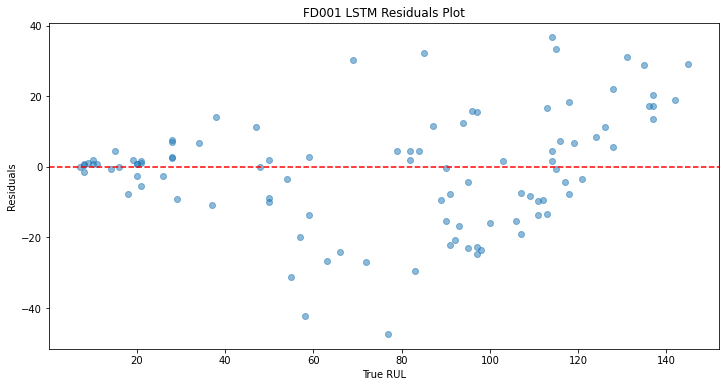

In [8]:
def plot_residuals(true_rul, predicted_rul):
    residuals = true_rul - predicted_rul
    plt.figure(figsize=(12, 6))
    plt.scatter(true_rul, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True RUL')
    plt.ylabel('Residuals')
    plt.title('FD001 LSTM Residuals Plot')
    plt.show()

# Assuming engine_preds is a list of arrays where each array contains predictions for a specific engine
last_preds = [pred[-1] for pred in engine_preds if len(pred) > 0]  # Ensure each prediction array has elements
last_preds = np.array(last_preds)  # Convert list to numpy array for consistent handling

# Recheck lengths
print(f"Length of true RUL after filtering: {len(true_rul)}")
print(f"Length of last predictions: {len(last_preds)}")

# Now let's try plotting again if lengths match
if len(true_rul) == len(last_preds):
    plot_residuals(true_rul, last_preds)
else:
    print("Error: The lengths of true RUL and last predictions do not match.")


## FD002

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD002.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD002.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD002.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Data processing functions are defined here (not shown to save space)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

train_df = pd.DataFrame(data=np.c_[train_df["engine_id"], train_scaled])
test_df = pd.DataFrame(data=np.c_[test_df["engine_id"], test_scaled])

# Prepare training data (not shown to save space)

# Prepare and filter test data
test_sequences, num_test_windows_list, processed_engine_ids = [], [], []
for engine_id in range(1, int(test_df[0].nunique()) + 1):
    engine_data = test_df[test_df[0] == engine_id].drop(columns=[0]).values
    if len(engine_data) < window_size:
        print(f"Skipping test engine {engine_id} due to insufficient data.")
        continue
    sequences, num_windows = prepare_test_sequences(engine_data, window_size, shift_step, num_test_windows)
    test_sequences.append(sequences)
    num_test_windows_list.append(num_windows)
    processed_engine_ids.append(engine_id - 1)  # Engine IDs are 1-indexed in your dataset

test_sequences = np.concatenate(test_sequences)
true_rul = true_rul_df.iloc[processed_engine_ids, 0].values  # Filter true RUL values based on processed engine IDs

# Model training and evaluation
# Define and compile model, fit model, and predict (not shown to save space)

# Predictions and evaluation
predicted_rul = model.predict(test_sequences).reshape(-1)
engine_preds = np.split(predicted_rul, np.cumsum(num_test_windows_list)[:-1])
mean_engine_preds = [np.mean(preds) for preds in engine_preds]
print(f"Length of filtered true RUL: {len(true_rul)}")
print(f"Length of predicted RUL: {len(mean_engine_preds)}")

# RMSE calculation
rmse = np.sqrt(mean_squared_error(true_rul, mean_engine_preds))
print(f"RMSE: {rmse}")

# Further evaluations such as S-score (not shown to save space)


Skipping test engine 28 due to insufficient data.
Skipping test engine 59 due to insufficient data.
Skipping test engine 83 due to insufficient data.
Skipping test engine 122 due to insufficient data.
Skipping test engine 201 due to insufficient data.
Skipping test engine 223 due to insufficient data.
40/40 [==============================] - 1s 15ms/step
Length of filtered true RUL: 253
Length of predicted RUL: 253
RMSE: 56.97122088304828


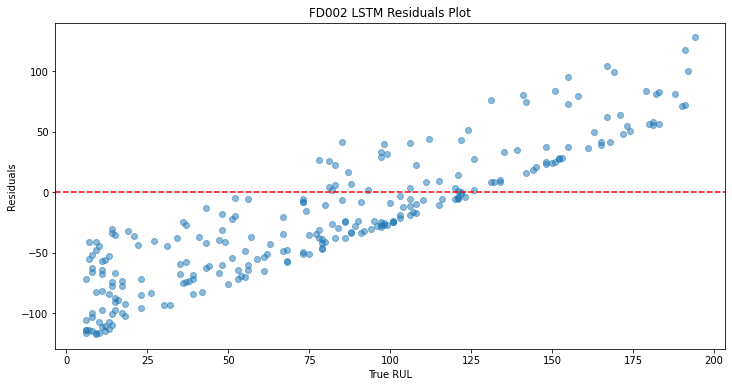

In [10]:
# Assuming engine_preds is a list of arrays where each array contains predictions for a specific engine
last_preds = [pred[-1] for pred in engine_preds if len(pred) > 0]  # Ensure each prediction array has elements
last_preds = np.array(last_preds)  # Convert list to numpy array for consistent handling

# Now you can try plotting residuals again
def plot_residuals(true_rul, predicted_rul):
    residuals = true_rul - predicted_rul
    plt.figure(figsize=(12, 6))
    plt.scatter(true_rul, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True RUL')
    plt.ylabel('Residuals')
    plt.title('FD002 LSTM Residuals Plot')
    plt.show()

plot_residuals(true_rul, last_preds)



## FD003

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD003.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD003.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD003.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Data processing functions are defined here (not shown to save space)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

train_df = pd.DataFrame(data=np.c_[train_df["engine_id"], train_scaled])
test_df = pd.DataFrame(data=np.c_[test_df["engine_id"], test_scaled])

# Prepare training data (not shown to save space)

# Prepare and filter test data
test_sequences, num_test_windows_list, processed_engine_ids = [], [], []
for engine_id in range(1, int(test_df[0].nunique()) + 1):
    engine_data = test_df[test_df[0] == engine_id].drop(columns=[0]).values
    if len(engine_data) < window_size:
        print(f"Skipping test engine {engine_id} due to insufficient data.")
        continue
    sequences, num_windows = prepare_test_sequences(engine_data, window_size, shift_step, num_test_windows)
    test_sequences.append(sequences)
    num_test_windows_list.append(num_windows)
    processed_engine_ids.append(engine_id - 1)  # Engine IDs are 1-indexed in your dataset

test_sequences = np.concatenate(test_sequences)
true_rul = true_rul_df.iloc[processed_engine_ids, 0].values  # Filter true RUL values based on processed engine IDs

# Model training and evaluation
# Define and compile model, fit model, and predict (not shown to save space)

# Predictions and evaluation
predicted_rul = model.predict(test_sequences).reshape(-1)
engine_preds = np.split(predicted_rul, np.cumsum(num_test_windows_list)[:-1])
mean_engine_preds = [np.mean(preds) for preds in engine_preds]
print(f"Length of filtered true RUL: {len(true_rul)}")
print(f"Length of predicted RUL: {len(mean_engine_preds)}")

# RMSE calculation
rmse = np.sqrt(mean_squared_error(true_rul, mean_engine_preds))
print(f"RMSE: {rmse}")

# Further evaluations such as S-score (not shown to save space)


16/16 [==============================] - 0s 16ms/step
Length of filtered true RUL: 100
Length of predicted RUL: 100
RMSE: 29.731047265831887


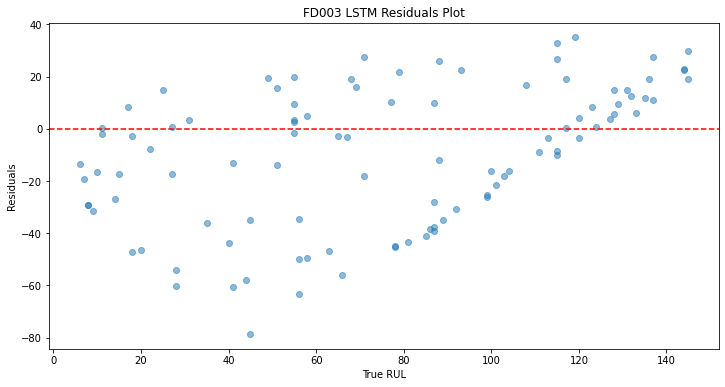

In [12]:
# Assuming engine_preds is a list of arrays where each array contains predictions for a specific engine
last_preds = [pred[-1] for pred in engine_preds if len(pred) > 0]  # Ensure each prediction array has elements
last_preds = np.array(last_preds)  # Convert list to numpy array for consistent handling

# Now you can try plotting residuals again
def plot_residuals(true_rul, predicted_rul):
    residuals = true_rul - predicted_rul
    plt.figure(figsize=(12, 6))
    plt.scatter(true_rul, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True RUL')
    plt.ylabel('Residuals')
    plt.title('FD003 LSTM Residuals Plot')
    plt.show()

plot_residuals(true_rul, last_preds)

## FD004

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD004.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD004.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD004.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Data processing functions are defined here (not shown to save space)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

train_df = pd.DataFrame(data=np.c_[train_df["engine_id"], train_scaled])
test_df = pd.DataFrame(data=np.c_[test_df["engine_id"], test_scaled])

# Prepare training data (not shown to save space)

# Prepare and filter test data
test_sequences, num_test_windows_list, processed_engine_ids = [], [], []
for engine_id in range(1, int(test_df[0].nunique()) + 1):
    engine_data = test_df[test_df[0] == engine_id].drop(columns=[0]).values
    if len(engine_data) < window_size:
        print(f"Skipping test engine {engine_id} due to insufficient data.")
        continue
    sequences, num_windows = prepare_test_sequences(engine_data, window_size, shift_step, num_test_windows)
    test_sequences.append(sequences)
    num_test_windows_list.append(num_windows)
    processed_engine_ids.append(engine_id - 1)  # Engine IDs are 1-indexed in your dataset

test_sequences = np.concatenate(test_sequences)
true_rul = true_rul_df.iloc[processed_engine_ids, 0].values  # Filter true RUL values based on processed engine IDs

# Model training and evaluation
# Define and compile model, fit model, and predict (not shown to save space)

# Predictions and evaluation
predicted_rul = model.predict(test_sequences).reshape(-1)
engine_preds = np.split(predicted_rul, np.cumsum(num_test_windows_list)[:-1])
mean_engine_preds = [np.mean(preds) for preds in engine_preds]
print(f"Length of filtered true RUL: {len(true_rul)}")
print(f"Length of predicted RUL: {len(mean_engine_preds)}")

# RMSE calculation
rmse = np.sqrt(mean_squared_error(true_rul, mean_engine_preds))
print(f"RMSE: {rmse}")

# Further evaluations such as S-score (not shown to save space)


Skipping test engine 10 due to insufficient data.
Skipping test engine 19 due to insufficient data.
Skipping test engine 28 due to insufficient data.
Skipping test engine 125 due to insufficient data.
Skipping test engine 141 due to insufficient data.
Skipping test engine 156 due to insufficient data.
Skipping test engine 164 due to insufficient data.
Skipping test engine 204 due to insufficient data.
Skipping test engine 229 due to insufficient data.
Skipping test engine 239 due to insufficient data.
Skipping test engine 246 due to insufficient data.
38/38 [==============================] - 1s 16ms/step
Length of filtered true RUL: 237
Length of predicted RUL: 237
RMSE: 56.822096718299356


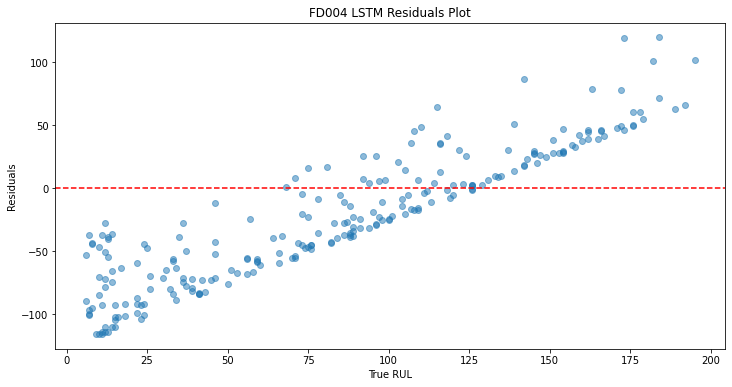

In [14]:
# Assuming engine_preds is a list of arrays where each array contains predictions for a specific engine
last_preds = [pred[-1] for pred in engine_preds if len(pred) > 0]  # Ensure each prediction array has elements
last_preds = np.array(last_preds)  # Convert list to numpy array for consistent handling

# Now you can try plotting residuals again
def plot_residuals(true_rul, predicted_rul):
    residuals = true_rul - predicted_rul
    plt.figure(figsize=(12, 6))
    plt.scatter(true_rul, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('True RUL')
    plt.ylabel('Residuals')
    plt.title('FD004 LSTM Residuals Plot')
    plt.show()

plot_residuals(true_rul, last_preds)

# 4. Random Forest Regressor

## FD001

RandomForest RMSE: 78.20763012412877


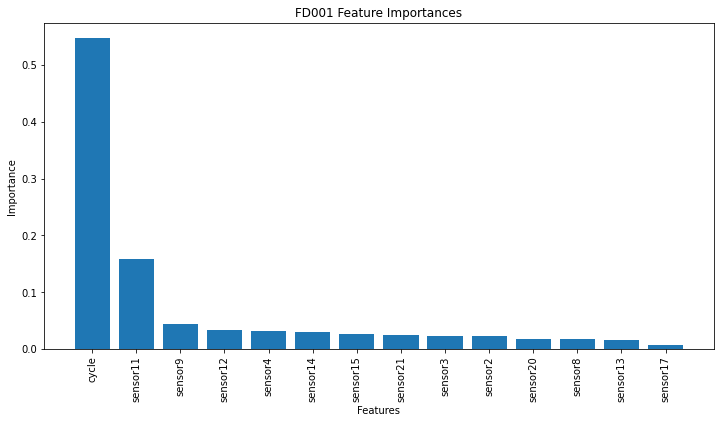

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(34)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD001.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD001.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD001.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

# Prepare training and test data for RandomForest
train_rf_df = pd.DataFrame(data=train_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
test_rf_df = pd.DataFrame(data=test_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
train_targets = train_df['RUL'].values

# Split training data for validation
train_rf_df, val_rf_df, train_targets, val_targets = train_test_split(train_rf_df, train_targets, test_size=0.2, random_state=34)

# Fit RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=34)
rf_model.fit(train_rf_df, train_targets)

# Predictions for RandomForestRegressor
rf_pred = rf_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['predicted_RUL'] = rf_pred
test_df['engine_id'] = test_df['engine_id'].astype(int)

aggregated_predictions = test_df.groupby('engine_id')['predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
rf_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_predictions))
print(f"RandomForest RMSE: {rf_rmse}")

# Feature importance plot
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title('FD001 Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importance(rf_model, [col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])


### Detailed Feature Analysis

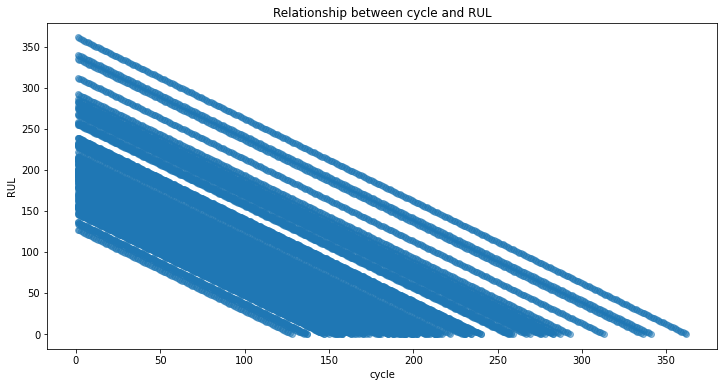

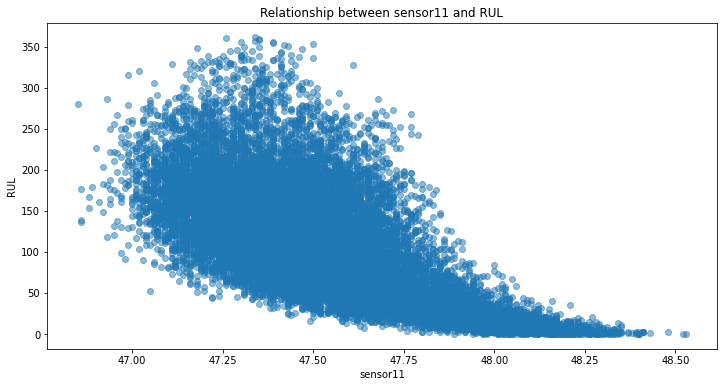

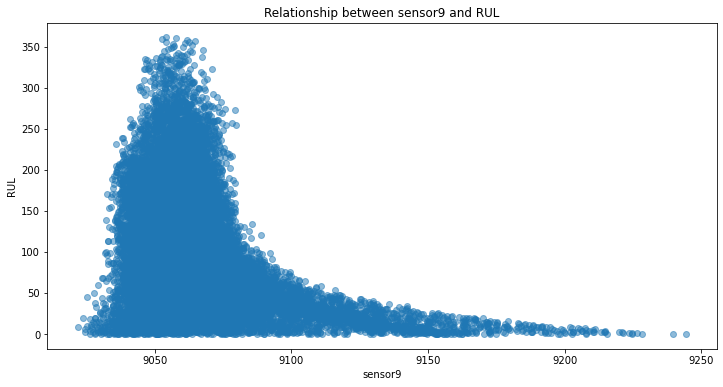

In [16]:
# Top 3 features
top_features = ['cycle', 'sensor11', 'sensor9']

for feature in top_features:
    plt.figure(figsize=(12, 6))
    plt.scatter(train_df[feature], train_df['RUL'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('RUL')
    plt.title(f'Relationship between {feature} and RUL')
    plt.show()


### Model Comparison

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Fit GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=34)
gb_model.fit(train_rf_df, train_targets)

# Predictions for GradientBoostingRegressor
gb_pred = gb_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['gb_predicted_RUL'] = gb_pred
aggregated_gb_predictions = test_df.groupby('engine_id')['gb_predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
gb_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_gb_predictions))
print(f"GradientBoosting RMSE: {gb_rmse}")


GradientBoosting RMSE: 77.37644893916196


### Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=34)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search.fit(train_rf_df, train_targets)

# Best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Best estimator
best_rf_model = grid_search.best_estimator_

# Predictions and evaluation for best RandomForestRegressor
best_rf_pred = best_rf_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['best_rf_predicted_RUL'] = best_rf_pred
aggregated_best_rf_predictions = test_df.groupby('engine_id')['best_rf_predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
best_rf_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_best_rf_predictions))
print(f"Best RandomForest RMSE: {best_rf_rmse}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best RandomForest RMSE: 77.1744316433283


### Residual Analysis

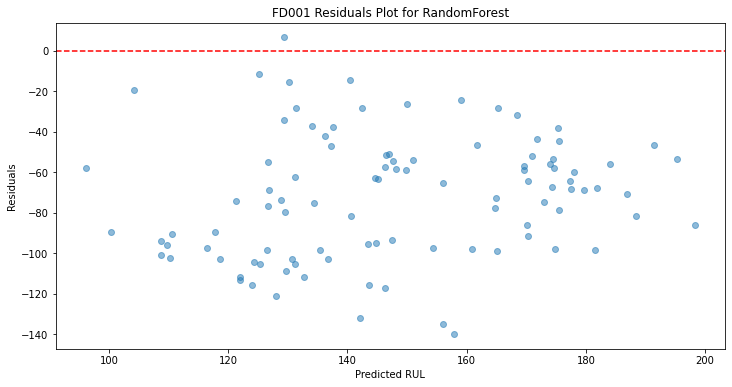

In [19]:
# Residuals for RandomForest
residuals_rf = true_rul_df.values.flatten() - aggregated_predictions.values

plt.figure(figsize=(12, 6))
plt.scatter(aggregated_predictions, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('FD001 Residuals Plot for RandomForest')
plt.show()


## FD002

RandomForest RMSE: 74.33425427700612


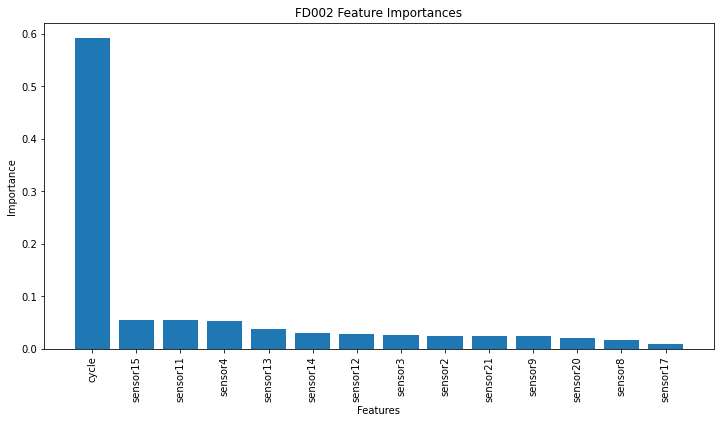

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(34)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD002.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD002.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD002.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

# Prepare training and test data for RandomForest
train_rf_df = pd.DataFrame(data=train_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
test_rf_df = pd.DataFrame(data=test_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
train_targets = train_df['RUL'].values

# Split training data for validation
train_rf_df, val_rf_df, train_targets, val_targets = train_test_split(train_rf_df, train_targets, test_size=0.2, random_state=34)

# Fit RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=34)
rf_model.fit(train_rf_df, train_targets)

# Predictions for RandomForestRegressor
rf_pred = rf_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['predicted_RUL'] = rf_pred
test_df['engine_id'] = test_df['engine_id'].astype(int)

aggregated_predictions = test_df.groupby('engine_id')['predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
rf_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_predictions))
print(f"RandomForest RMSE: {rf_rmse}")

# Feature importance plot
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title('FD002 Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importance(rf_model, [col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])


### Residual Analysis

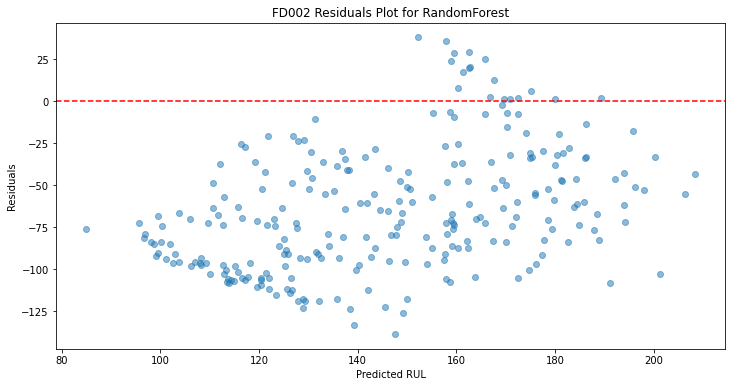

In [21]:
# Residuals for RandomForest
residuals_rf = true_rul_df.values.flatten() - aggregated_predictions.values

plt.figure(figsize=(12, 6))
plt.scatter(aggregated_predictions, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('FD002 Residuals Plot for RandomForest')
plt.show()

## FD003

RandomForest RMSE: 113.94404036177184


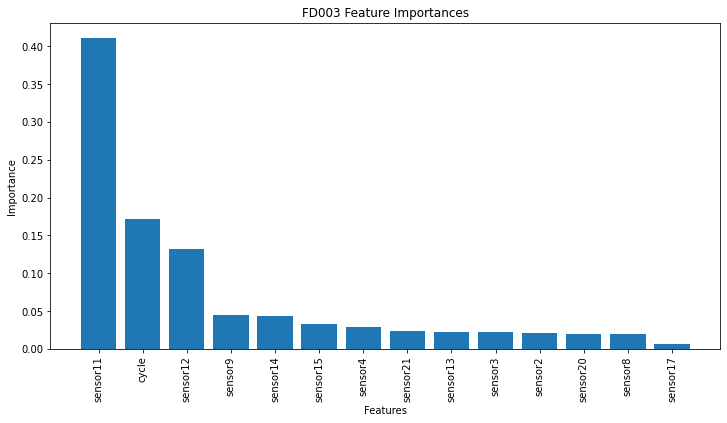

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(34)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD003.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD003.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD003.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

# Prepare training and test data for RandomForest
train_rf_df = pd.DataFrame(data=train_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
test_rf_df = pd.DataFrame(data=test_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
train_targets = train_df['RUL'].values

# Split training data for validation
train_rf_df, val_rf_df, train_targets, val_targets = train_test_split(train_rf_df, train_targets, test_size=0.2, random_state=34)

# Fit RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=34)
rf_model.fit(train_rf_df, train_targets)

# Predictions for RandomForestRegressor
rf_pred = rf_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['predicted_RUL'] = rf_pred
test_df['engine_id'] = test_df['engine_id'].astype(int)

aggregated_predictions = test_df.groupby('engine_id')['predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
rf_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_predictions))
print(f"RandomForest RMSE: {rf_rmse}")

# Feature importance plot
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title('FD003 Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importance(rf_model, [col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])


### Residual Analysis

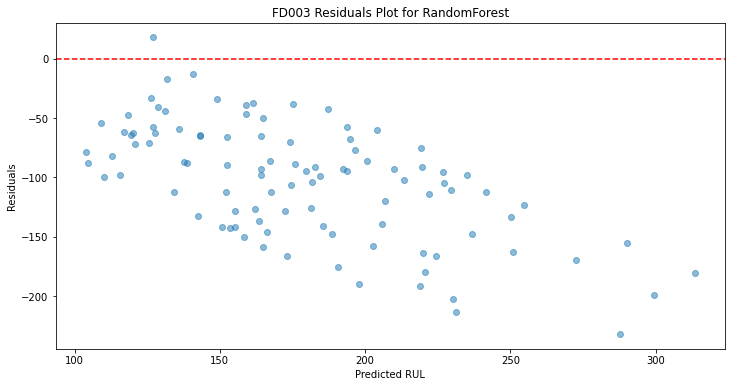

In [23]:
# Residuals for RandomForest
residuals_rf = true_rul_df.values.flatten() - aggregated_predictions.values

plt.figure(figsize=(12, 6))
plt.scatter(aggregated_predictions, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('FD003 Residuals Plot for RandomForest')
plt.show()

## FD004

RandomForest RMSE: 100.9559815723231


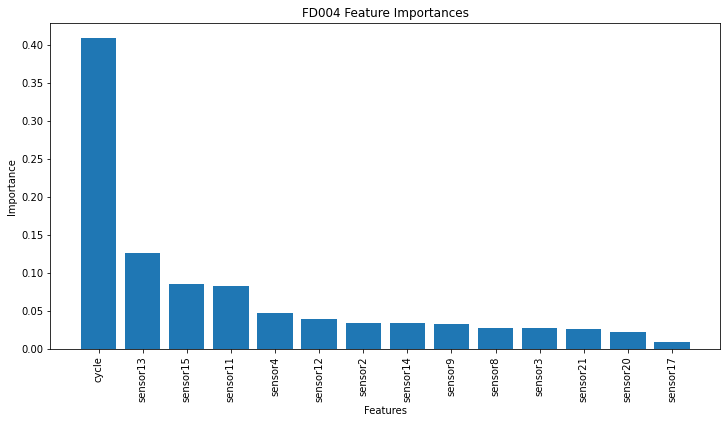

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
np.random.seed(34)

# Load and preprocess data
col_names = ["engine_id", "cycle", "setting1", "setting2", "setting3"] + [f"sensor{i}" for i in range(1, 22)]
train_df = pd.read_csv("train_FD004.txt", sep="\s+", header=None, names=col_names)
test_df = pd.read_csv("test_FD004.txt", sep="\s+", header=None, names=col_names)
true_rul_df = pd.read_csv("RUL_FD004.txt", sep='\s+', header=None)

# Add RUL column
train_df['RUL'] = train_df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# Scaling and preparing data
columns_to_drop = ['setting1', 'setting2', 'setting3', 'sensor1', 'sensor5', 'sensor6', 'sensor7', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=columns_to_drop + ['RUL', 'engine_id']))
test_scaled = scaler.transform(test_df.drop(columns=columns_to_drop + ['engine_id']))

# Prepare training and test data for RandomForest
train_rf_df = pd.DataFrame(data=train_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
test_rf_df = pd.DataFrame(data=test_scaled, columns=[col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])
train_targets = train_df['RUL'].values

# Split training data for validation
train_rf_df, val_rf_df, train_targets, val_targets = train_test_split(train_rf_df, train_targets, test_size=0.2, random_state=34)

# Fit RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=34)
rf_model.fit(train_rf_df, train_targets)

# Predictions for RandomForestRegressor
rf_pred = rf_model.predict(test_rf_df)

# Aggregate predictions by engine_id
test_df['predicted_RUL'] = rf_pred
test_df['engine_id'] = test_df['engine_id'].astype(int)

aggregated_predictions = test_df.groupby('engine_id')['predicted_RUL'].mean()

# Compare aggregated predictions to true RUL values
rf_rmse = np.sqrt(mean_squared_error(true_rul_df, aggregated_predictions))
print(f"RandomForest RMSE: {rf_rmse}")

# Feature importance plot
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title('FD004 Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

plot_feature_importance(rf_model, [col for col in col_names if col not in columns_to_drop + ['RUL', 'engine_id']])


### Residual Analysis

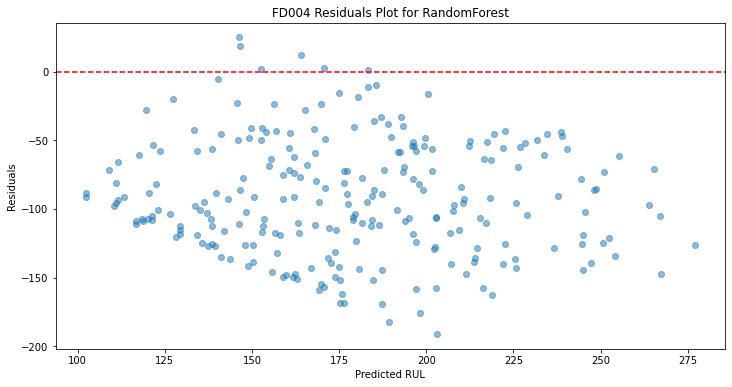

In [25]:
# Residuals for RandomForest
residuals_rf = true_rul_df.values.flatten() - aggregated_predictions.values

plt.figure(figsize=(12, 6))
plt.scatter(aggregated_predictions, residuals_rf, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.title('FD004 Residuals Plot for RandomForest')
plt.show()

# 5. Q-Learning Robot

## Integration of Q-Learning Robot into the Predictive Maintenance Project

To integrate the Q-Learning robot into your predictive maintenance project for the NASA CMAPSS dataset, we will follow these steps:

State Representation: Define how the sensor measurements and operational settings will be converted into a state.

Reward Function: Define a reward function based on the prediction accuracy of the Remaining Useful Life (RUL).

Training the Q-Learning Agent: Use the Q-Learning agent to learn policies for maintenance decisions based on the state and reward.

Evaluation: Evaluate the performance of the Q-Learning agent and compare it with other models.

Reporting: Document the process and results in the project report.

### 1. State Representation

In [27]:
def state_mapper(sensor_data, num_states):
    # Normalize the hash value to be within the range [0, num_states-1]
    return hash(tuple(sensor_data)) % num_states

### 2. Reward Function

In [28]:
def get_reward(predicted_rul, true_rul):
    return -abs(predicted_rul - true_rul)

### 3. Training the Q-Learning Agent

This Q-Learner code is adapted from one that I used in another module.

In [29]:
import numpy as np
import pandas as pd
import random

class QLearner:
    def __init__(self, num_states, num_actions, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=0, verbose=False):
        """
        Q-Learner constructor.
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.rar = rar
        self.radr = radr
        self.dyna = dyna
        self.verbose = verbose

        # Initialize Q-table
        self.Q = np.zeros((num_states, num_actions))

        # Initialize current state and action
        self.s = 0  # Current state
        self.a = 0  # Current action

        # Dyna-Q model if dyna is greater than zero
        if dyna > 0:
            self.model = {}

    def querysetstate(self, s):
        """
        Set the state and choose an initial action.
        """
        self.s = s
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s, :])

        self.a = action  # Save the action chosen
        return action

    def query(self, s_prime, r):
        """
        Update the Q table and determine the next action.
        """
        # Update Q-value for last action taken
        self.Q[self.s, self.a] += self.alpha * (r + self.gamma * np.max(self.Q[s_prime, :]) - self.Q[self.s, self.a])

        # Dyna-Q: Model learning and planning
        if self.dyna > 0:
            self.model[(self.s, self.a)] = (r, s_prime)
            for _ in range(self.dyna):
                s_rand, a_rand = random.choice(list(self.model.keys()))
                r_rand, s_prime_rand = self.model[(s_rand, a_rand)]
                self.Q[s_rand, a_rand] += self.alpha * (r_rand + self.gamma * np.max(self.Q[s_prime_rand, :]) - self.Q[s_rand, a_rand])

        # Decide next action
        self.s = s_prime
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s_prime, :])

        self.a = action  # Update action
        self.rar *= self.radr  # Decay exploration rate
        return action

    def author(self):
        return "jquek7"

# Function to map dataset to Q-Learner's state space
def state_mapper(sensor_data, num_states):
    # Normalize the hash value to be within the range [0, num_states-1]
    return hash(tuple(sensor_data)) % num_states

# Function to define reward based on RUL prediction accuracy
def get_reward(predicted_rul, true_rul):
    return -abs(predicted_rul - true_rul)

# Function to predict RUL (dummy function)
def predict_rul(state):
    # Use your trained model here for actual prediction
    return random.randint(0, 100)

# Function to get the true RUL from the dataset (dummy function)
def get_true_rul(engine_id, current_cycle):
    # Use your dataset to get the true RUL
    return random.randint(0, 100)

# Main function to run Q-Learning
def run_qlearning(train_data, test_data, rul_data, learner, num_states):
    for engine_id in train_data['unit_number'].unique():
        engine_data = train_data[train_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)  # Map sensor data to state
            action = learner.querysetstate(state)

            # Get the next state and reward
            if cycle < len(engine_data) - 1:
                next_state = state_mapper(engine_data.iloc[cycle + 1, 2:], num_states)
                reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))
            else:
                next_state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
                reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))

            learner.query(next_state, reward)

    # Evaluate on test data
    total_reward = 0
    for engine_id in test_data['unit_number'].unique():
        engine_data = test_data[test_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
            action = learner.querysetstate(state)
            reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))
            total_reward += reward

    print(f"Total Reward: {total_reward}")

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Define file paths for FD001, FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Number of states for Q-Learner
num_states = 1000

# Process each dataset with Q-Learning
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name} with Q-Learning...")
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

    learner = QLearner(num_states=num_states, num_actions=2, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=200, verbose=True)
    run_qlearning(train_data, test_data, rul_data, learner, num_states)


Processing FD001 with Q-Learning...
Total Reward: -442953
Processing FD002 with Q-Learning...
Total Reward: -1145271
Processing FD003 with Q-Learning...
Total Reward: -558420
Processing FD004 with Q-Learning...
Total Reward: -1391218


### 4. Updated Q-Learning Implementation for Predictive Maintenance

Note that the codes below are still a work-in-progress, and they only work for FD001

In [30]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

class QLearner:
    def __init__(self, num_states, num_actions, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=0, verbose=False):
        """
        Q-Learner constructor.
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.rar = rar
        self.radr = radr
        self.dyna = dyna
        self.verbose = verbose

        # Initialize Q-table
        self.Q = np.zeros((num_states, num_actions))

        # Initialize current state and action
        self.s = 0  # Current state
        self.a = 0  # Current action

        # Dyna-Q model if dyna is greater than zero
        if dyna > 0:
            self.model = {}

    def querysetstate(self, s):
        """
        Set the state and choose an initial action.
        """
        self.s = s
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s, :])

        self.a = action  # Save the action chosen
        return action

    def query(self, s_prime, r):
        """
        Update the Q table and determine the next action.
        """
        # Update Q-value for last action taken
        self.Q[self.s, self.a] += self.alpha * (r + self.gamma * np.max(self.Q[s_prime, :]) - self.Q[self.s, self.a])

        # Dyna-Q: Model learning and planning
        if self.dyna > 0:
            self.model[(self.s, self.a)] = (r, s_prime)
            for _ in range(self.dyna):
                s_rand, a_rand = random.choice(list(self.model.keys()))
                r_rand, s_prime_rand = self.model[(s_rand, a_rand)]
                self.Q[s_rand, a_rand] += self.alpha * (r_rand + self.gamma * np.max(self.Q[s_prime_rand, :]) - self.Q[s_rand, a_rand])

        # Decide next action
        self.s = s_prime
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s_prime, :])

        self.a = action  # Update action
        self.rar *= self.radr  # Decay exploration rate
        return action

    def author(self):
        return "jquek7"

# Function to map dataset to Q-Learner's state space
def state_mapper(sensor_data, num_states):
    # Normalize the hash value to be within the range [0, num_states-1]
    return hash(tuple(sensor_data)) % num_states

# Function to define reward based on RUL prediction accuracy
def get_reward(predicted_rul, true_rul):
    return -abs(predicted_rul - true_rul)

# Function to predict RUL using the Q-Learner
def predict_rul(engine_data, learner, num_states):
    predictions = []
    for cycle in range(len(engine_data)):
        state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
        action = learner.querysetstate(state)
        predicted_rul = learner.Q[state, action]  # Assuming Q-values reflect the RUL predictions
        predictions.append(predicted_rul)
    return predictions

# Function to get the true RUL from the dataset
def get_true_rul(engine_id, rul_data):
    return rul_data.iloc[engine_id - 1]['RUL']

# Function to evaluate predictions
def evaluate_predictions(true_rul, predicted_rul):
    mse = mean_squared_error(true_rul, predicted_rul)
    rmse = mean_squared_error(true_rul, predicted_rul, squared=False)
    mae = mean_absolute_error(true_rul, predicted_rul)
    r2 = r2_score(true_rul, predicted_rul)
    ev = explained_variance_score(true_rul, predicted_rul)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print(f"Explained Variance: {ev}")

# Main function to run Q-Learning
def run_qlearning(train_data, test_data, rul_data, learner, num_states):
    for engine_id in train_data['unit_number'].unique():
        engine_data = train_data[train_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)  # Map sensor data to state
            action = learner.querysetstate(state)

            # Get the next state and reward
            if cycle < len(engine_data) - 1:
                next_state = state_mapper(engine_data.iloc[cycle + 1, 2:], num_states)
                reward = get_reward(predict_rul(engine_data.iloc[cycle:cycle+1], learner, num_states)[0], get_true_rul(engine_id, rul_data))
            else:
                next_state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
                reward = get_reward(predict_rul(engine_data.iloc[cycle:cycle+1], learner, num_states)[0], get_true_rul(engine_id, rul_data))

            learner.query(next_state, reward)

    # Evaluate on test data
    total_reward = 0
    for engine_id in test_data['unit_number'].unique():
        engine_data = test_data[test_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
            action = learner.querysetstate(state)
            reward = get_reward(predict_rul(engine_data.iloc[cycle:cycle+1], learner, num_states)[0], get_true_rul(engine_id, rul_data))
            total_reward += reward

    print(f"Total Reward: {total_reward}")

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Define file paths for FD001, FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Number of states for Q-Learner
num_states = 1000

# Process each dataset with Q-Learning
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name} with Q-Learning...")
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

    learner = QLearner(num_states=num_states, num_actions=2, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=200, verbose=True)
    run_qlearning(train_data, test_data, rul_data, learner, num_states)

    # Make predictions
    # We should get predictions for each unique engine
    predicted_rul = []
    for engine_id in test_data['unit_number'].unique():
        engine_data = test_data[test_data['unit_number'] == engine_id]
        predicted_rul.append(predict_rul(engine_data, learner, num_states)[-1])  # Use the last cycle's prediction
    true_rul = rul_data['RUL'].values

    # Evaluate predictions
    evaluate_predictions(true_rul, predicted_rul)


Processing FD001 with Q-Learning...
Total Reward: -1.951228110141075e+19
RMSE: 1563346232915088.5
MAE: 1432471657810660.5
MSE: 2.444051443969798e+30
R-squared: -1.4153074696374285e+27
Explained Variance: -2.2704458607585398e+26
Processing FD002 with Q-Learning...


IndexError: single positional indexer is out-of-bounds

In [26]:
import numpy as np
import pandas as pd
import random

class QLearner:
    def __init__(self, num_states, num_actions, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=0, verbose=False):
        """
        Q-Learner constructor.
        """
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.rar = rar
        self.radr = radr
        self.dyna = dyna
        self.verbose = verbose

        # Initialize Q-table
        self.Q = np.zeros((num_states, num_actions))

        # Initialize current state and action
        self.s = 0  # Current state
        self.a = 0  # Current action

        # Dyna-Q model if dyna is greater than zero
        if dyna > 0:
            self.model = {}

    def querysetstate(self, s):
        """
        Set the state and choose an initial action.
        """
        self.s = s
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s, :])

        self.a = action  # Save the action chosen
        return action

    def query(self, s_prime, r):
        """
        Update the Q table and determine the next action.
        """
        # Update Q-value for last action taken
        self.Q[self.s, self.a] += self.alpha * (r + self.gamma * np.max(self.Q[s_prime, :]) - self.Q[self.s, self.a])

        # Dyna-Q: Model learning and planning
        if self.dyna > 0:
            self.model[(self.s, self.a)] = (r, s_prime)
            for _ in range(self.dyna):
                s_rand, a_rand = random.choice(list(self.model.keys()))
                r_rand, s_prime_rand = self.model[(s_rand, a_rand)]
                self.Q[s_rand, a_rand] += self.alpha * (r_rand + self.gamma * np.max(self.Q[s_prime_rand, :]) - self.Q[s_rand, a_rand])

        # Decide next action
        self.s = s_prime
        if random.random() < self.rar:
            action = random.randint(0, self.num_actions - 1)
        else:
            action = np.argmax(self.Q[s_prime, :])

        self.a = action  # Update action
        self.rar *= self.radr  # Decay exploration rate
        return action

    def author(self):
        return "jquek7"

# Function to map dataset to Q-Learner's state space
def state_mapper(sensor_data, num_states):
    # Normalize the hash value to be within the range [0, num_states-1]
    return hash(tuple(sensor_data)) % num_states

# Function to define reward based on RUL prediction accuracy
def get_reward(predicted_rul, true_rul):
    return -abs(predicted_rul - true_rul)

# Function to predict RUL (dummy function)
def predict_rul(state):
    # Use your trained model here for actual prediction
    return random.randint(0, 100)

# Function to get the true RUL from the dataset (dummy function)
def get_true_rul(engine_id, current_cycle):
    # Use your dataset to get the true RUL
    return random.randint(0, 100)

# Main function to run Q-Learning
def run_qlearning(train_data, test_data, rul_data, learner, num_states):
    for engine_id in train_data['unit_number'].unique():
        engine_data = train_data[train_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)  # Map sensor data to state
            action = learner.querysetstate(state)

            # Get the next state and reward
            if cycle < len(engine_data) - 1:
                next_state = state_mapper(engine_data.iloc[cycle + 1, 2:], num_states)
                reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))
            else:
                next_state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
                reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))

            learner.query(next_state, reward)

    # Evaluate on test data
    total_reward = 0
    for engine_id in test_data['unit_number'].unique():
        engine_data = test_data[test_data['unit_number'] == engine_id]
        for cycle in range(len(engine_data)):
            state = state_mapper(engine_data.iloc[cycle, 2:], num_states)
            action = learner.querysetstate(state)
            reward = get_reward(predict_rul(state), get_true_rul(engine_id, cycle))
            total_reward += reward

    print(f"Total Reward: {total_reward}")

# Define column names
columns = ['unit_number', 'time_in_cycles'] + [f'operational_setting_{i}' for i in range(1, 4)] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Define file paths for FD001, FD002, FD003, and FD004 datasets
datasets = {
    'FD001': ('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt'),
    'FD002': ('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt'),
    'FD003': ('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt'),
    'FD004': ('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')
}

# Number of states for Q-Learner
num_states = 1000

# Process each dataset with Q-Learning
for name, (train_file, test_file, rul_file) in datasets.items():
    print(f"Processing {name} with Q-Learning...")
    train_data = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test_data = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul_data = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

    learner = QLearner(num_states=num_states, num_actions=2, alpha=0.2, gamma=0.9, rar=0.5, radr=0.99, dyna=200, verbose=True)
    run_qlearning(train_data, test_data, rul_data, learner, num_states)


Processing FD001 with Q-Learning...
Total Reward: -442303
Processing FD002 with Q-Learning...


KeyboardInterrupt: 